In [1]:
#Produced for WaterProgrammingBlog
#Peter Storm
#pqs4@cornell.edu
#Example adapted from Josue Medellin-Azuara & Richard Howitt


In [2]:
import scipy.optimize
from functools import partial

In [3]:
###Data Set###
###Region 1###
#data are arranged [alfalfa, vine, corn]
#price is $/ton
crop_prices = [132, 700, 250]
#yield in ton/acre
crop_yields = [7, 6.5, 6]
#costs are $/acre
crop_costs = [681, 3478, 1000]


In [4]:
###Observed Data###
#data are arranged [alfalfa, vine, corn]
#acres of crops watered
irrigated_crop_acres = [100, 30, 200]
total_irrigated = sum(irrigated_crop_acres)
total_available_land = total_irrigated
#water application rates (ft per unit area)
applied_water_rates = [4, 1.5, 2.5]


In [5]:
#loops to populate additional information
#revenues from crops, $/acre
crop_revenues = []
#total applied water, acre-ft
applied_water = []
#observed net returns for a given crop ($), acres * (revenue - cost)
obs_net_returns = []
net_return_per_acre = []
for i in range(len(crop_prices)):
    crop_revenues.append(crop_prices[i] * crop_yields[i])
    applied_water.append(applied_water_rates[i] * irrigated_crop_acres[i])
    obs_net_returns.append(irrigated_crop_acres[i] * (crop_revenues[i] - crop_costs[i]))
    net_return_per_acre.append(crop_revenues[i] - crop_costs[i])
    
total_applied_water = sum(applied_water)

In [6]:
#create calibration constraints for solver
#Decouples the calibration from constraints to ensure a unique outcome (Howitt, 1995)
cal_mult = 1.0001
cal_acre_constraints = []
for i in range(len(irrigated_crop_acres)):
    cal_acre_constraints.append(irrigated_crop_acres[i] * cal_mult)

In [7]:
#define constraints for model
#note that for inequalities, the sum is to be calibrated to greater than or equal to 0
#So we need to make sure that extra water or land remains, so contraint minus the calibrated amount
def irr_acres_constr(cal_irr_acres, 
                     total_irrigated_water=total_irrigated):
    #limits the total irrigated acres in model to calibrated total
    return total_irrigated_water - sum(cal_irr_acres)
def applied_water_constr(cal_irr_acres, 
                         applied_water_rates=applied_water_rates, 
                         total_applied_water=total_applied_water):
    #limits water applied in calibration to total applied in data
    total_water = 0
    for i in range(len(applied_water_rates)):
        total_water += applied_water_rates[i] * cal_irr_acres[i]
    return total_applied_water - total_water

#need to create number of constraints based on number of crops
def crop0(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[0] - cal_irr_acres[0]

def crop1(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[1] - cal_irr_acres[1]

def crop2(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[2] - cal_irr_acres[2]

#create dictionary of constraints
cons = [{'type':'ineq', 'fun': irr_acres_constr},
        {'type':'ineq', 'fun': applied_water_constr},
        {'type':'ineq', 'fun': crop0},
        {'type':'ineq', 'fun': crop1},
        {'type':'ineq', 'fun': crop2},
       ]

#establish parameters for model
guess_irr_acres = [50, 50, 50]

#bounds for model
bnds = ((0, total_available_land), (0, total_available_land), (0, total_available_land))

In [8]:
def calc_observed_net_revenue(guess_irr_acres, applied_water_rates=applied_water_rates):
    """
    Calculates the total net revenues for all crops, negative since minimizing
    Inputs need to be lists of equal lengths with respective crops lined up
    """
    total_net_revenue = 0
    for i in range(len(applied_water_rates)):
        total_net_revenue += net_return_per_acre[i] * guess_irr_acres[i]
    
    return -1 * total_net_revenue

In [9]:
#run the model to fit parameters
results = scipy.optimize.minimize(calc_observed_net_revenue, #function to minimize
                                  x0=guess_irr_acres,
                                  method='SLSQP',
                                  bounds=bnds,
                                  constraints=cons)
                                  

In [10]:
results

     fun: -156467.62700369937
     jac: array([ -243., -1072.,  -500.])
 message: 'Optimization terminated successfully.'
    nfev: 11
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 99.977,  30.003, 200.02 ])

In [11]:
###shadow price crop 0###

def crop0(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[0] - cal_irr_acres[0] + 1

def crop1(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[1] - cal_irr_acres[1]

def crop2(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[2] - cal_irr_acres[2]

#create dictionary of constraints
cons = [{'type':'ineq', 'fun': irr_acres_constr},
        {'type':'ineq', 'fun': applied_water_constr},
        {'type':'ineq', 'fun': crop0},
        {'type':'ineq', 'fun': crop1},
        {'type':'ineq', 'fun': crop2},
       ]

#establish parameters for model
guess_irr_acres = [50, 50, 50]

#bounds for model
bnds = ((0, total_available_land), (0, total_available_land), (0, total_available_land))

results0 = scipy.optimize.minimize(calc_observed_net_revenue, #function to minimize
                                  x0=guess_irr_acres,
                                  method='SLSQP',
                                  bounds=bnds,
                                  constraints=cons)
shadow_0 = results.fun - results0.fun                    

###shadow price crop 1###

def crop0(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[0] - cal_irr_acres[0] 

def crop1(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[1] - cal_irr_acres[1] + 1

def crop2(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[2] - cal_irr_acres[2]

#create dictionary of constraints
cons = [{'type':'ineq', 'fun': irr_acres_constr},
        {'type':'ineq', 'fun': applied_water_constr},
        {'type':'ineq', 'fun': crop0},
        {'type':'ineq', 'fun': crop1},
        {'type':'ineq', 'fun': crop2},
       ]

#establish parameters for model
guess_irr_acres = [50, 50, 50]

#bounds for model
bnds = ((0, total_available_land), (0, total_available_land), (0, total_available_land))

results1 = scipy.optimize.minimize(calc_observed_net_revenue, #function to minimize
                                  x0=guess_irr_acres,
                                  method='SLSQP',
                                  bounds=bnds,
                                  constraints=cons)
shadow_1 = results.fun - results1.fun       

###shadow price crop 2###

def crop0(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[0] - cal_irr_acres[0] 

def crop1(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[1] - cal_irr_acres[1] 

def crop2(cal_irr_acres, cal_acre_constraints=cal_acre_constraints):
    return cal_acre_constraints[2] - cal_irr_acres[2] + 1

#create dictionary of constraints
cons = [{'type':'ineq', 'fun': irr_acres_constr},
        {'type':'ineq', 'fun': applied_water_constr},
        {'type':'ineq', 'fun': crop0},
        {'type':'ineq', 'fun': crop1},
        {'type':'ineq', 'fun': crop2},
       ]

#establish parameters for model
guess_irr_acres = [50, 50, 50]

#bounds for model
bnds = ((0, total_available_land), (0, total_available_land), (0, total_available_land))

results2 = scipy.optimize.minimize(calc_observed_net_revenue, #function to minimize
                                  x0=guess_irr_acres,
                                  method='SLSQP',
                                  bounds=bnds,
                                  constraints=cons)
shadow_2 = results.fun - results2.fun  



In [12]:
lagrange_mults = [shadow_0, shadow_1, shadow_2]
#calculate PMP parameters
alpha = []
gamma = []

for i in range(len(lagrange_mults)):
    alpha.append(crop_costs[i] - lagrange_mults[i])
    gamma.append(2 * lagrange_mults[i] / irrigated_crop_acres[i])
print(alpha)
print(gamma)

[681.0, 2649.0000186886755, 742.9998857077735]
[0.0, 55.26666542075497, 2.570001142922265]


In [13]:
##Solve calibrated model##

def pmp_net_revenue(guess_irr_acres, alpha=alpha, gamma=gamma,
                    applied_water_rates=applied_water_rates, crop_revenues=crop_revenues):
    """
    Calculates the total net revenues for all crops using PMP, negative since minimizing
    Inputs need to be lists of equal lengths with respective crops lined up
    """
    revenue = 0
    pmp_cost = 0
    for i in range(len(guess_irr_acres)):
        revenue += crop_revenues[i] * guess_irr_acres[i] 
        pmp_cost += alpha[i] * guess_irr_acres[i] + 0.5 * gamma[i] * guess_irr_acres[i] ** 2
    return (pmp_cost - revenue)

#setting constraints
water_available = 945 #in acre-ft
land_available = 330 #in acres
def irr_acres_constr(cal_irr_acres, land_available=land_available):
    #limits the total irrigated acres to land available

    return land_available - sum(cal_irr_acres)

def applied_water_constr(cal_irr_acres, applied_water_rates=applied_water_rates, water_available=water_available):
    #limits water applied in calibration to total applied in data
    total_water = 0
    for i in range(len(applied_water_rates)):
        total_water += applied_water_rates[i] * cal_irr_acres[i]

    return water_available - total_water

#create dictionary of constraints
cons = [{'type':'ineq', 'fun': irr_acres_constr},
        {'type':'ineq', 'fun': applied_water_constr}]

#establish parameters for model
guess_irr_acres = [50, 50, 50]

#bounds for model
bnds = ((0, land_available), (0, land_available), (0, land_available))

#run calibrated model
pmp_results = scipy.optimize.minimize(pmp_net_revenue, #function to minimize
                                  x0=guess_irr_acres,
                                  method='SLSQP',
                                  bounds=bnds,
                                  constraints=cons)
print(pmp_results)

     fun: -156460.00000351854
     jac: array([-243., -243., -243.])
 message: 'Optimization terminated successfully.'
    nfev: 52
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 99.99905443,  29.99995182, 200.00099377])


In [14]:
###time to graph
from numpy import *
import math
import matplotlib.pyplot as plt


In [15]:
alfalfa_params = [alpha[0], gamma[0]]
vine_params = [alpha[1], gamma[1]]
corn_params = [alpha[2], gamma[2]]



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "bottom center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


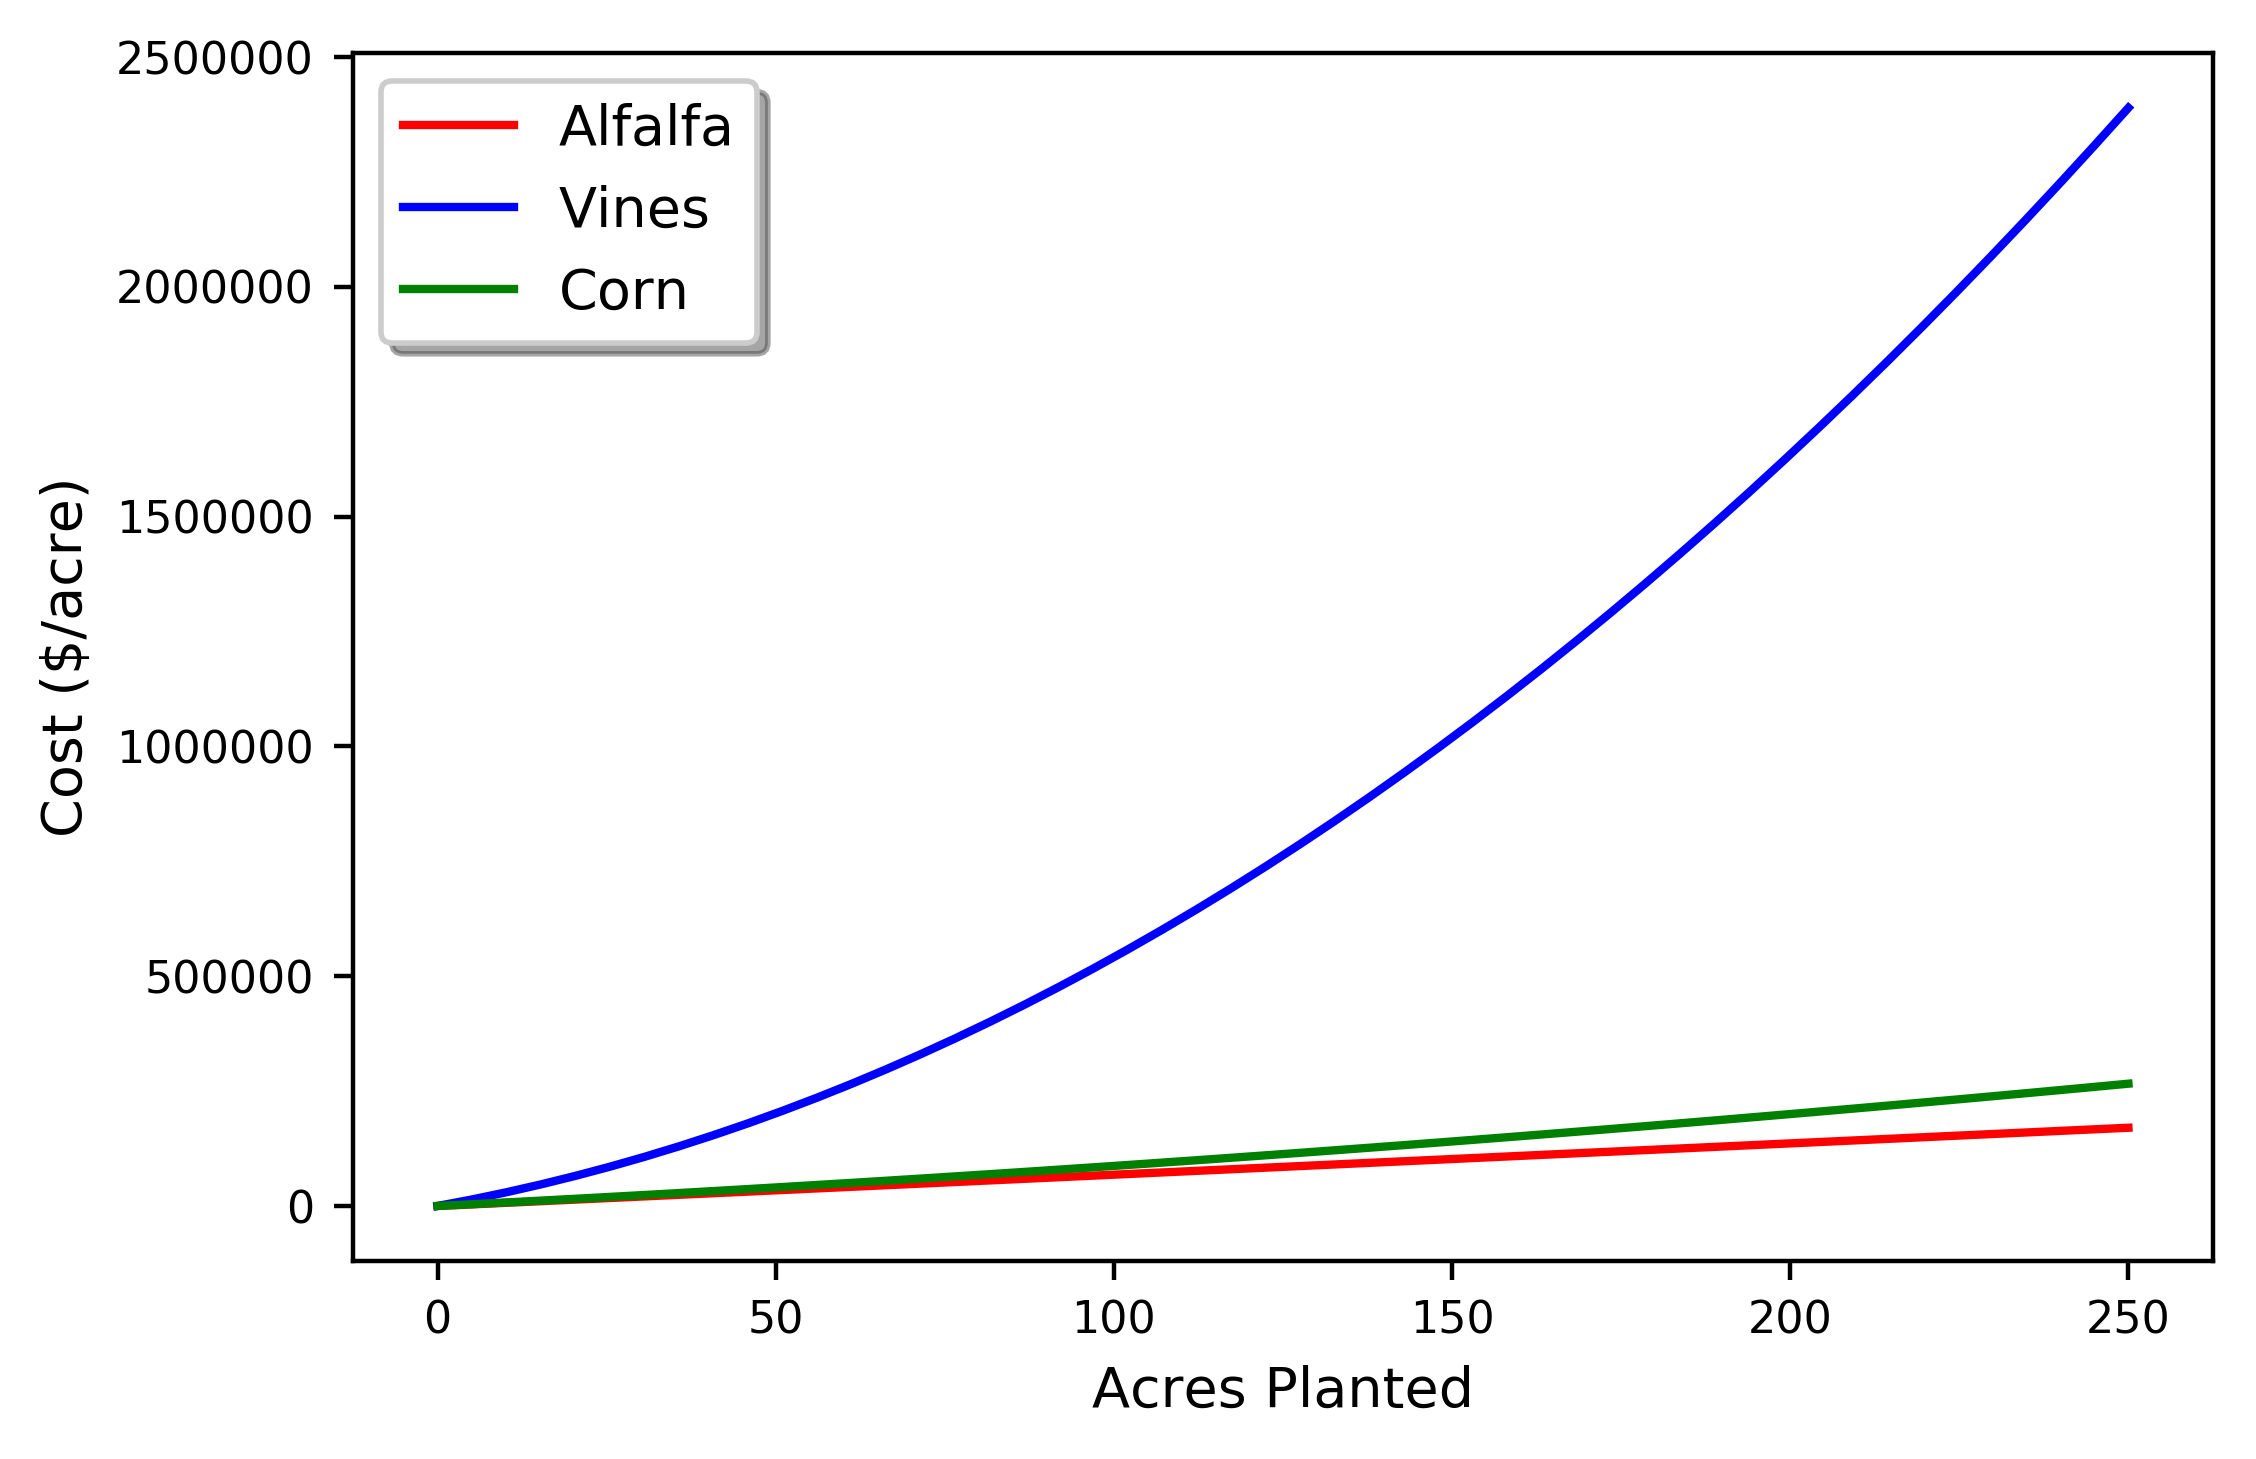

In [16]:
#graph the total cost
t = linspace(0, 250)

alfalfa = alfalfa_params[0] * t + 0.5 * alfalfa_params[1] * t ** 2
vine = vine_params[0] * t + 0.5 * vine_params[1] * t ** 2
corn = corn_params[0] * t + 0.5 * corn_params[1] * t ** 2


plt.figure(dpi=400)
plt.ylabel('Cost ($/acre)')
plt.xlabel('Acres Planted')

plt.plot(t, alfalfa, 'r', label='Alfalfa')
plt.plot(t, vine, 'b', label='Vines')
plt.plot(t, corn, 'g', label='Corn')
# plt.plot(t, driver_c, '--', 'b', label='Harvest Function, H')
# plt.ylim((0,7))
plt.tick_params(labelsize=8)

legend = plt.legend(loc='bottom center', shadow=True)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "bottom center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


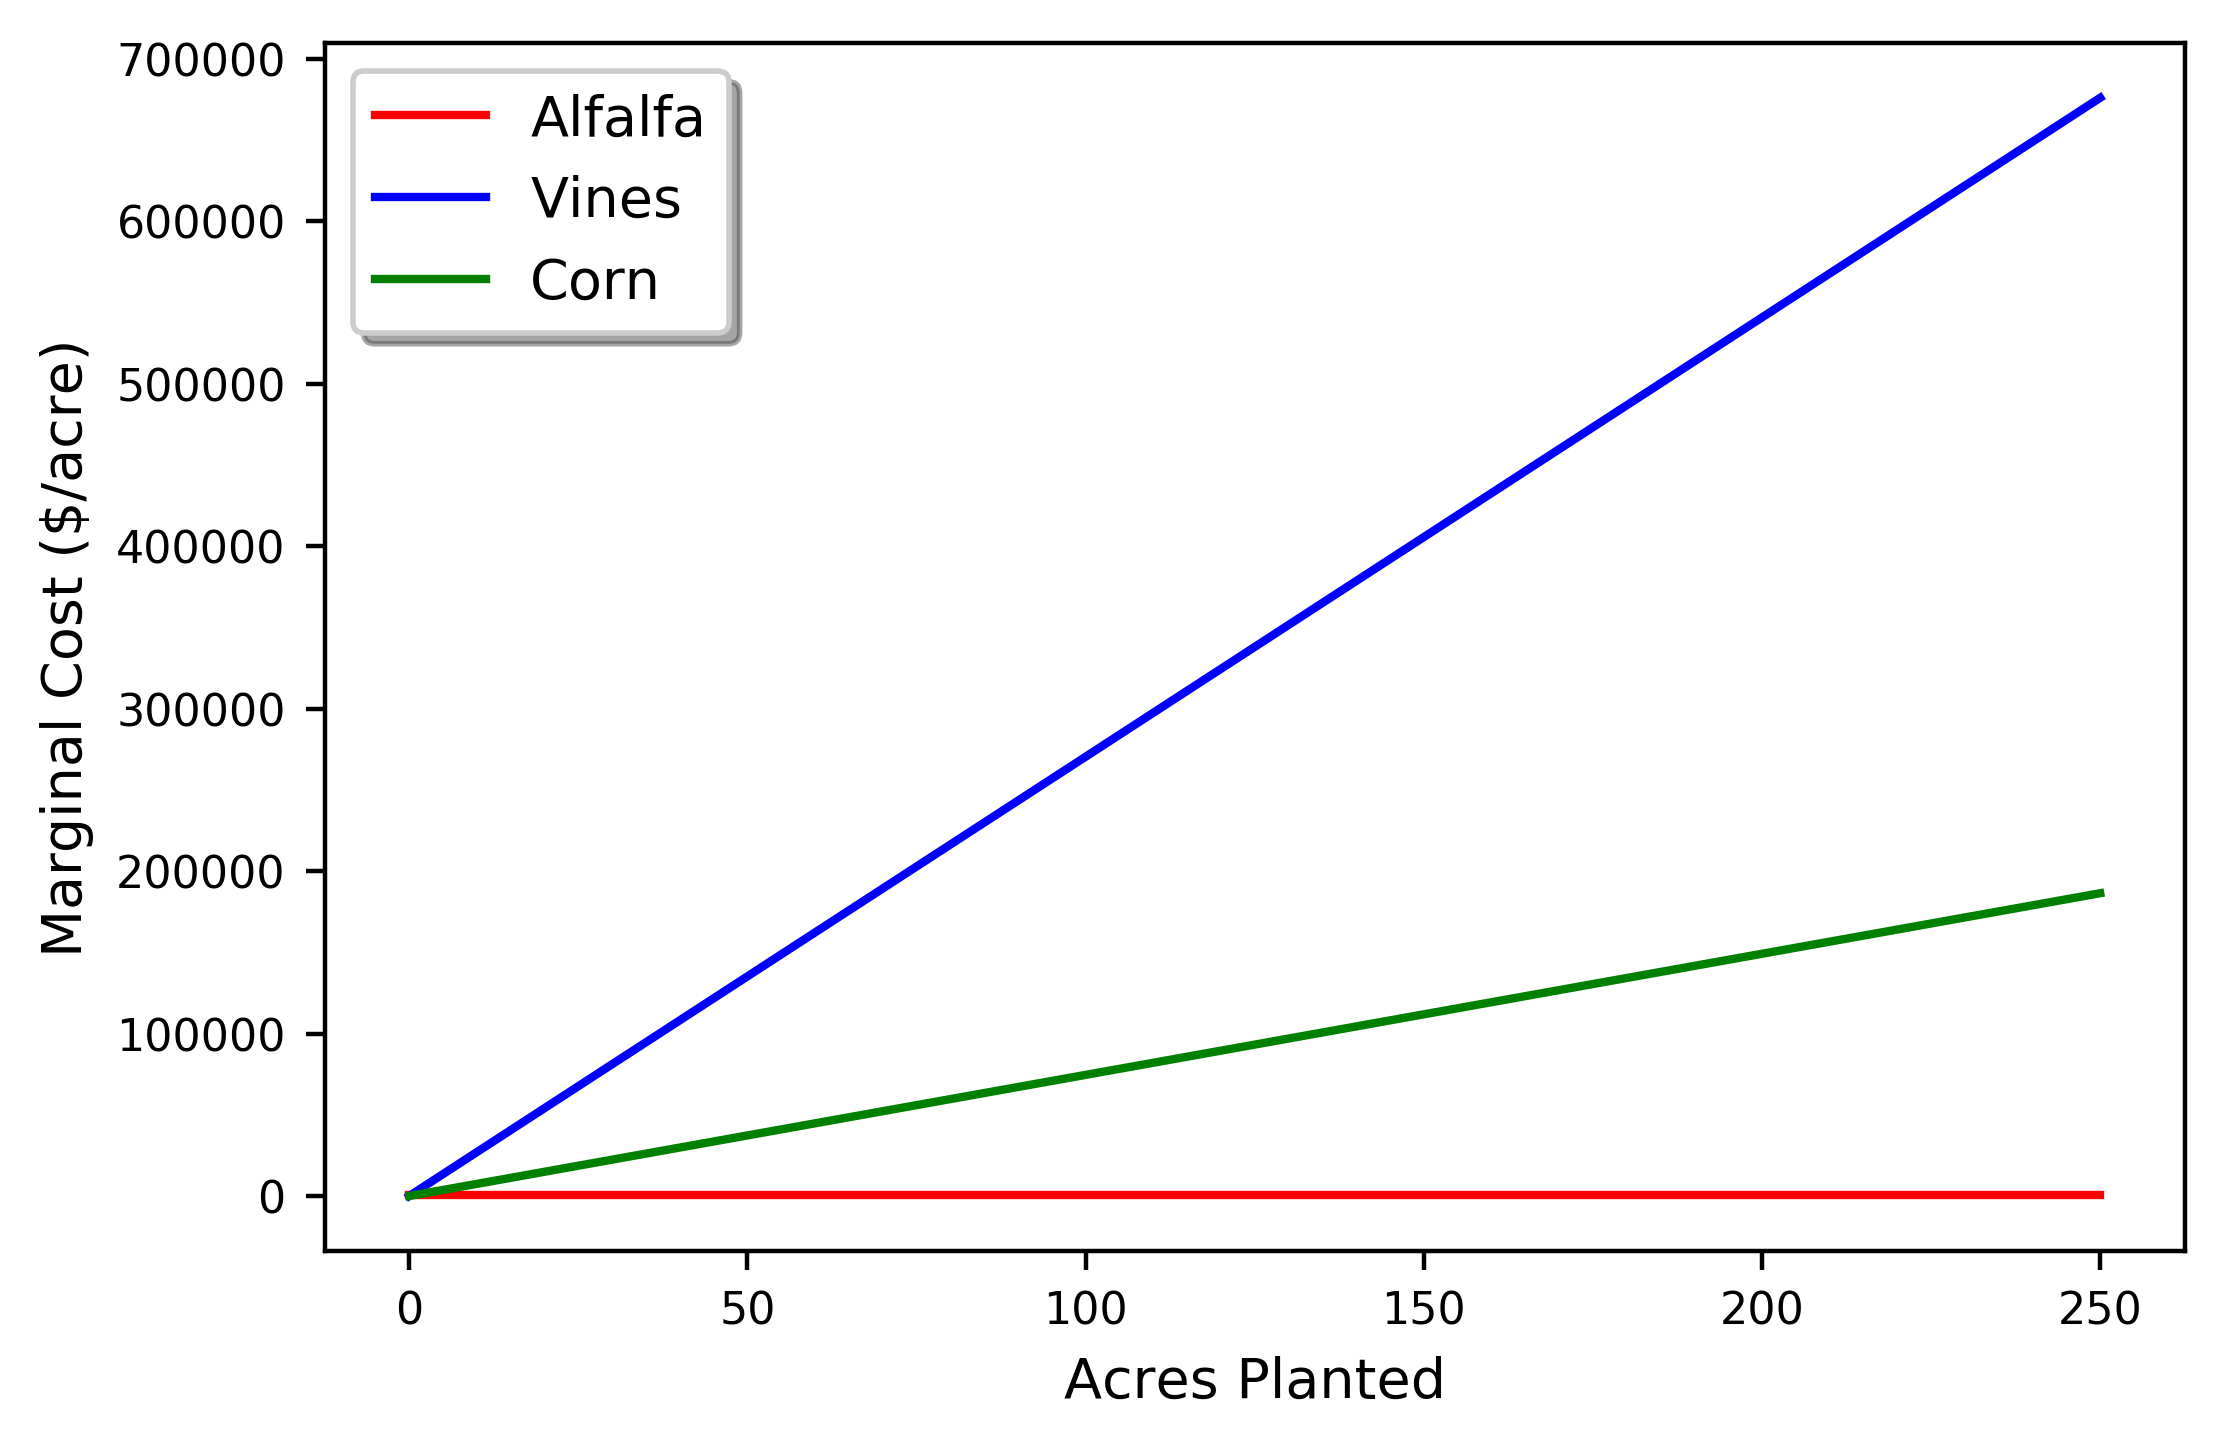

In [17]:
#graph the marginal costs
t = linspace(0, 250)

alfalfa = alfalfa_params[0]  + alfalfa_params[1] * t 
vine = vine_params[0] * t + vine_params[1] * t 
corn = corn_params[0] * t + corn_params[1] * t 


plt.figure(dpi=400)
plt.ylabel('Marginal Cost ($/acre)')
plt.xlabel('Acres Planted')

plt.plot(t, alfalfa, 'r', label='Alfalfa')
plt.plot(t, vine, 'b', label='Vines')
plt.plot(t, corn, 'g', label='Corn')
# plt.plot(t, driver_c, '--', 'b', label='Harvest Function, H')
# plt.ylim((0,7))
plt.tick_params(labelsize=8)

legend = plt.legend(loc='bottom center', shadow=True)
plt.show()

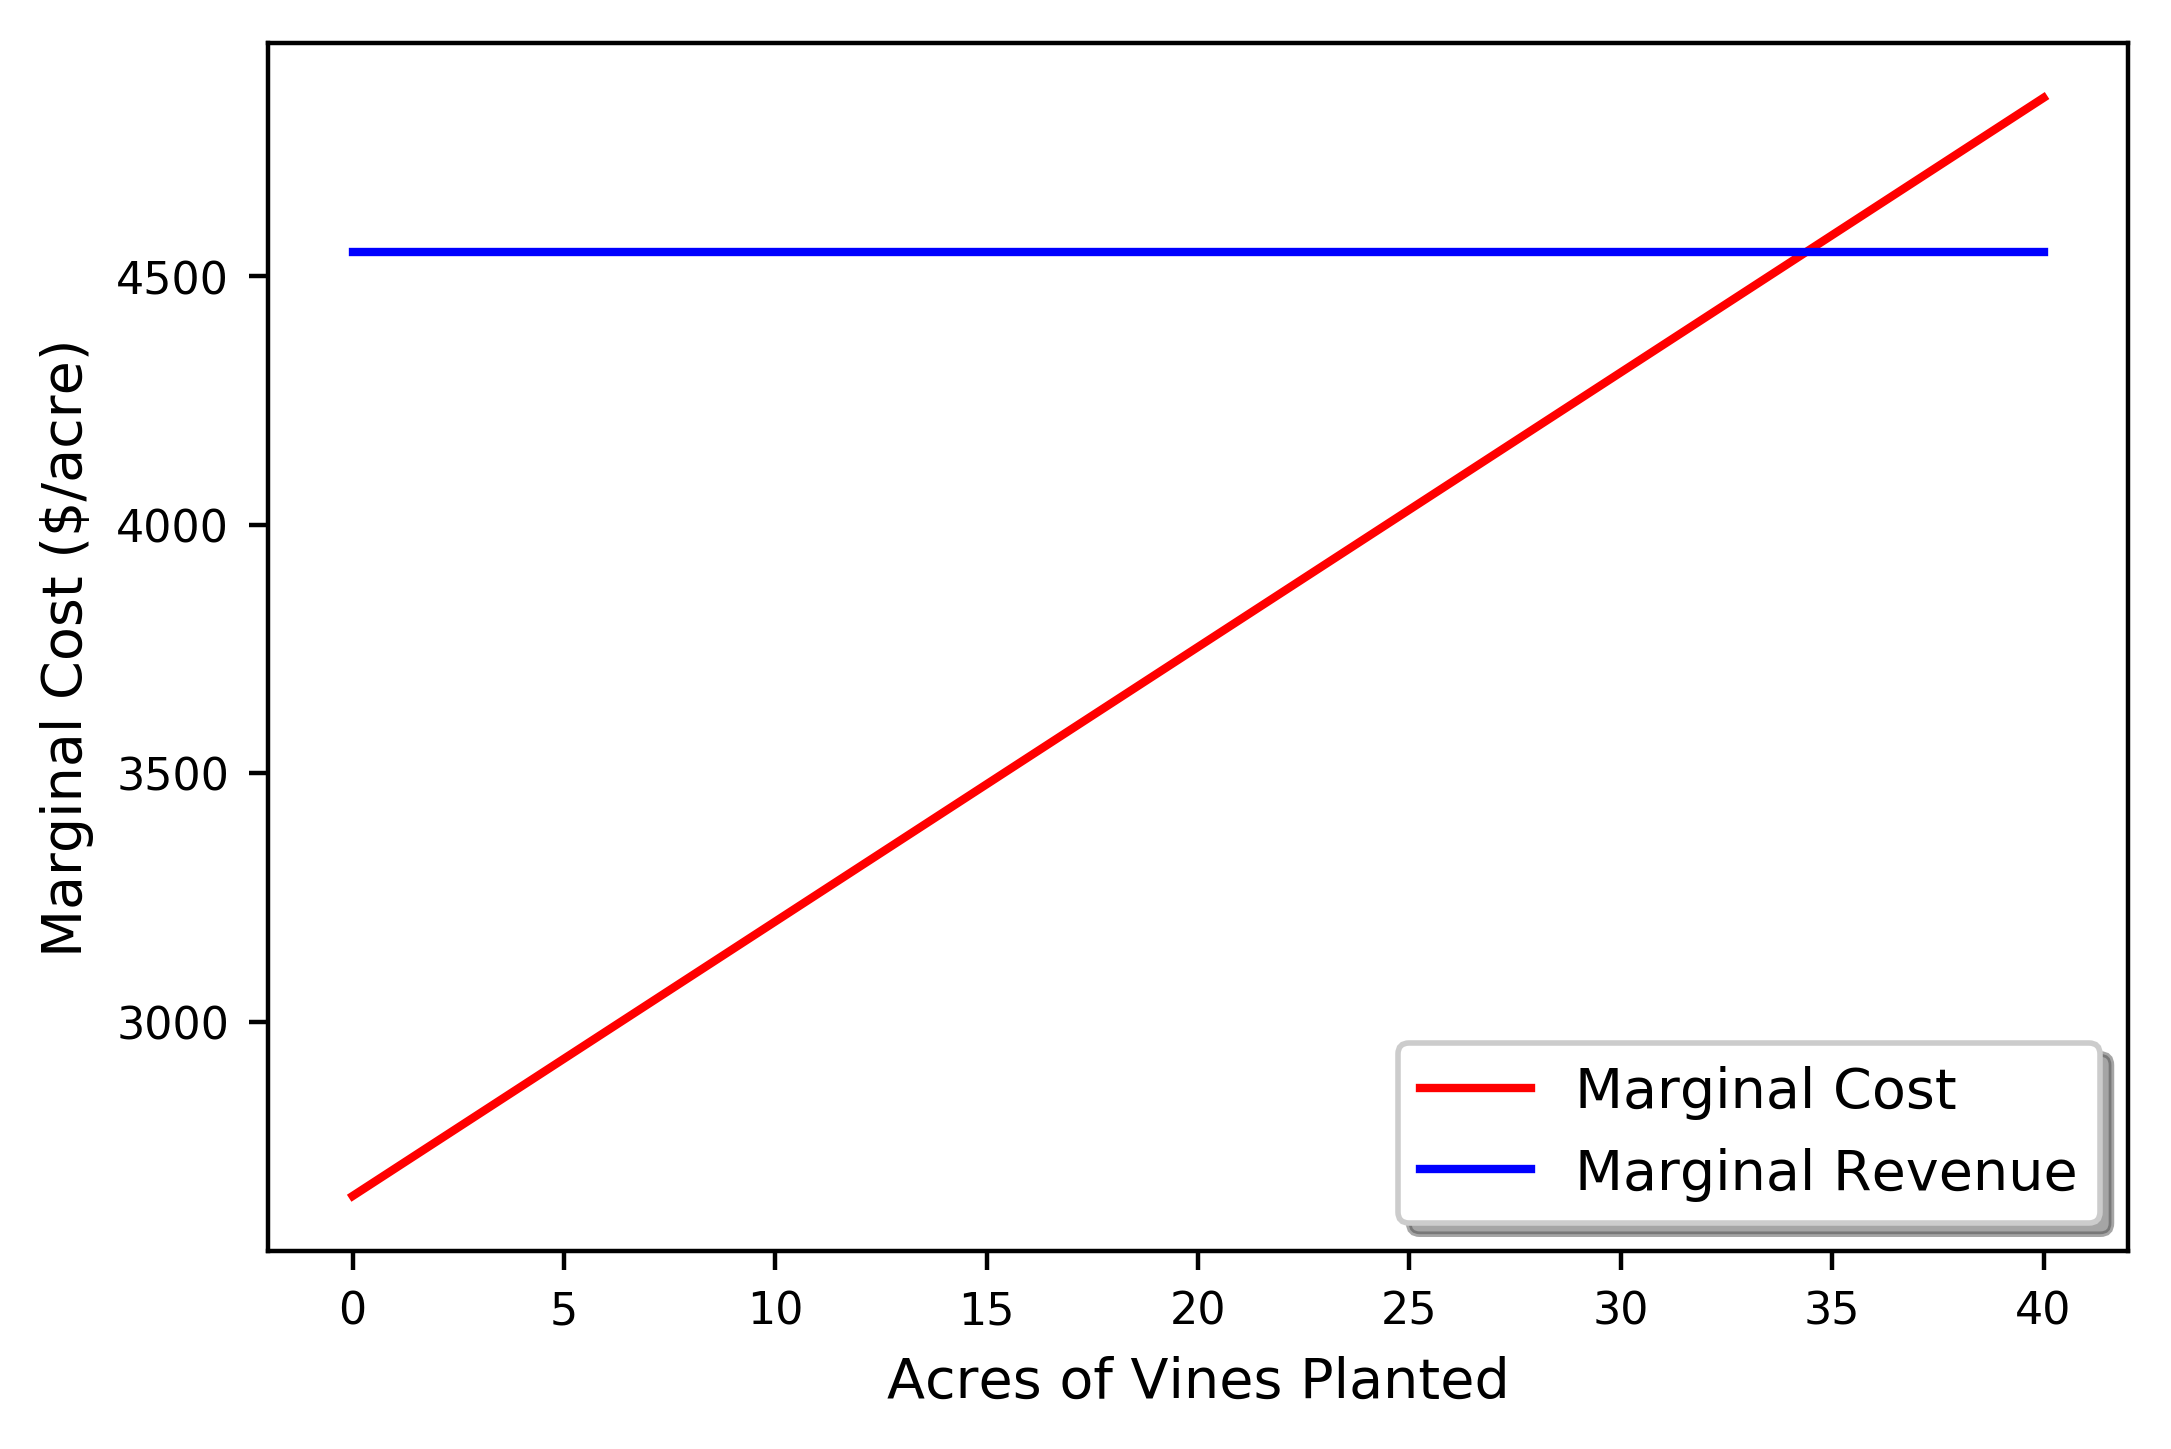

In [18]:
#graph the marginal costs
t = linspace(0, 40)

vine = vine_params[0]  + vine_params[1] * t 
vine_total = crop_revenues[1] + 0 * t


plt.figure(dpi=400)
plt.ylabel('Marginal Cost ($/acre)')
plt.xlabel('Acres of Vines Planted')

plt.plot(t, vine, 'r', label='Marginal Cost')
plt.plot(t, vine_total, 'b', label='Marginal Revenue')

# plt.ylim((0,7))
plt.tick_params(labelsize=8)

legend = plt.legend(loc=4, shadow=True)
plt.show()

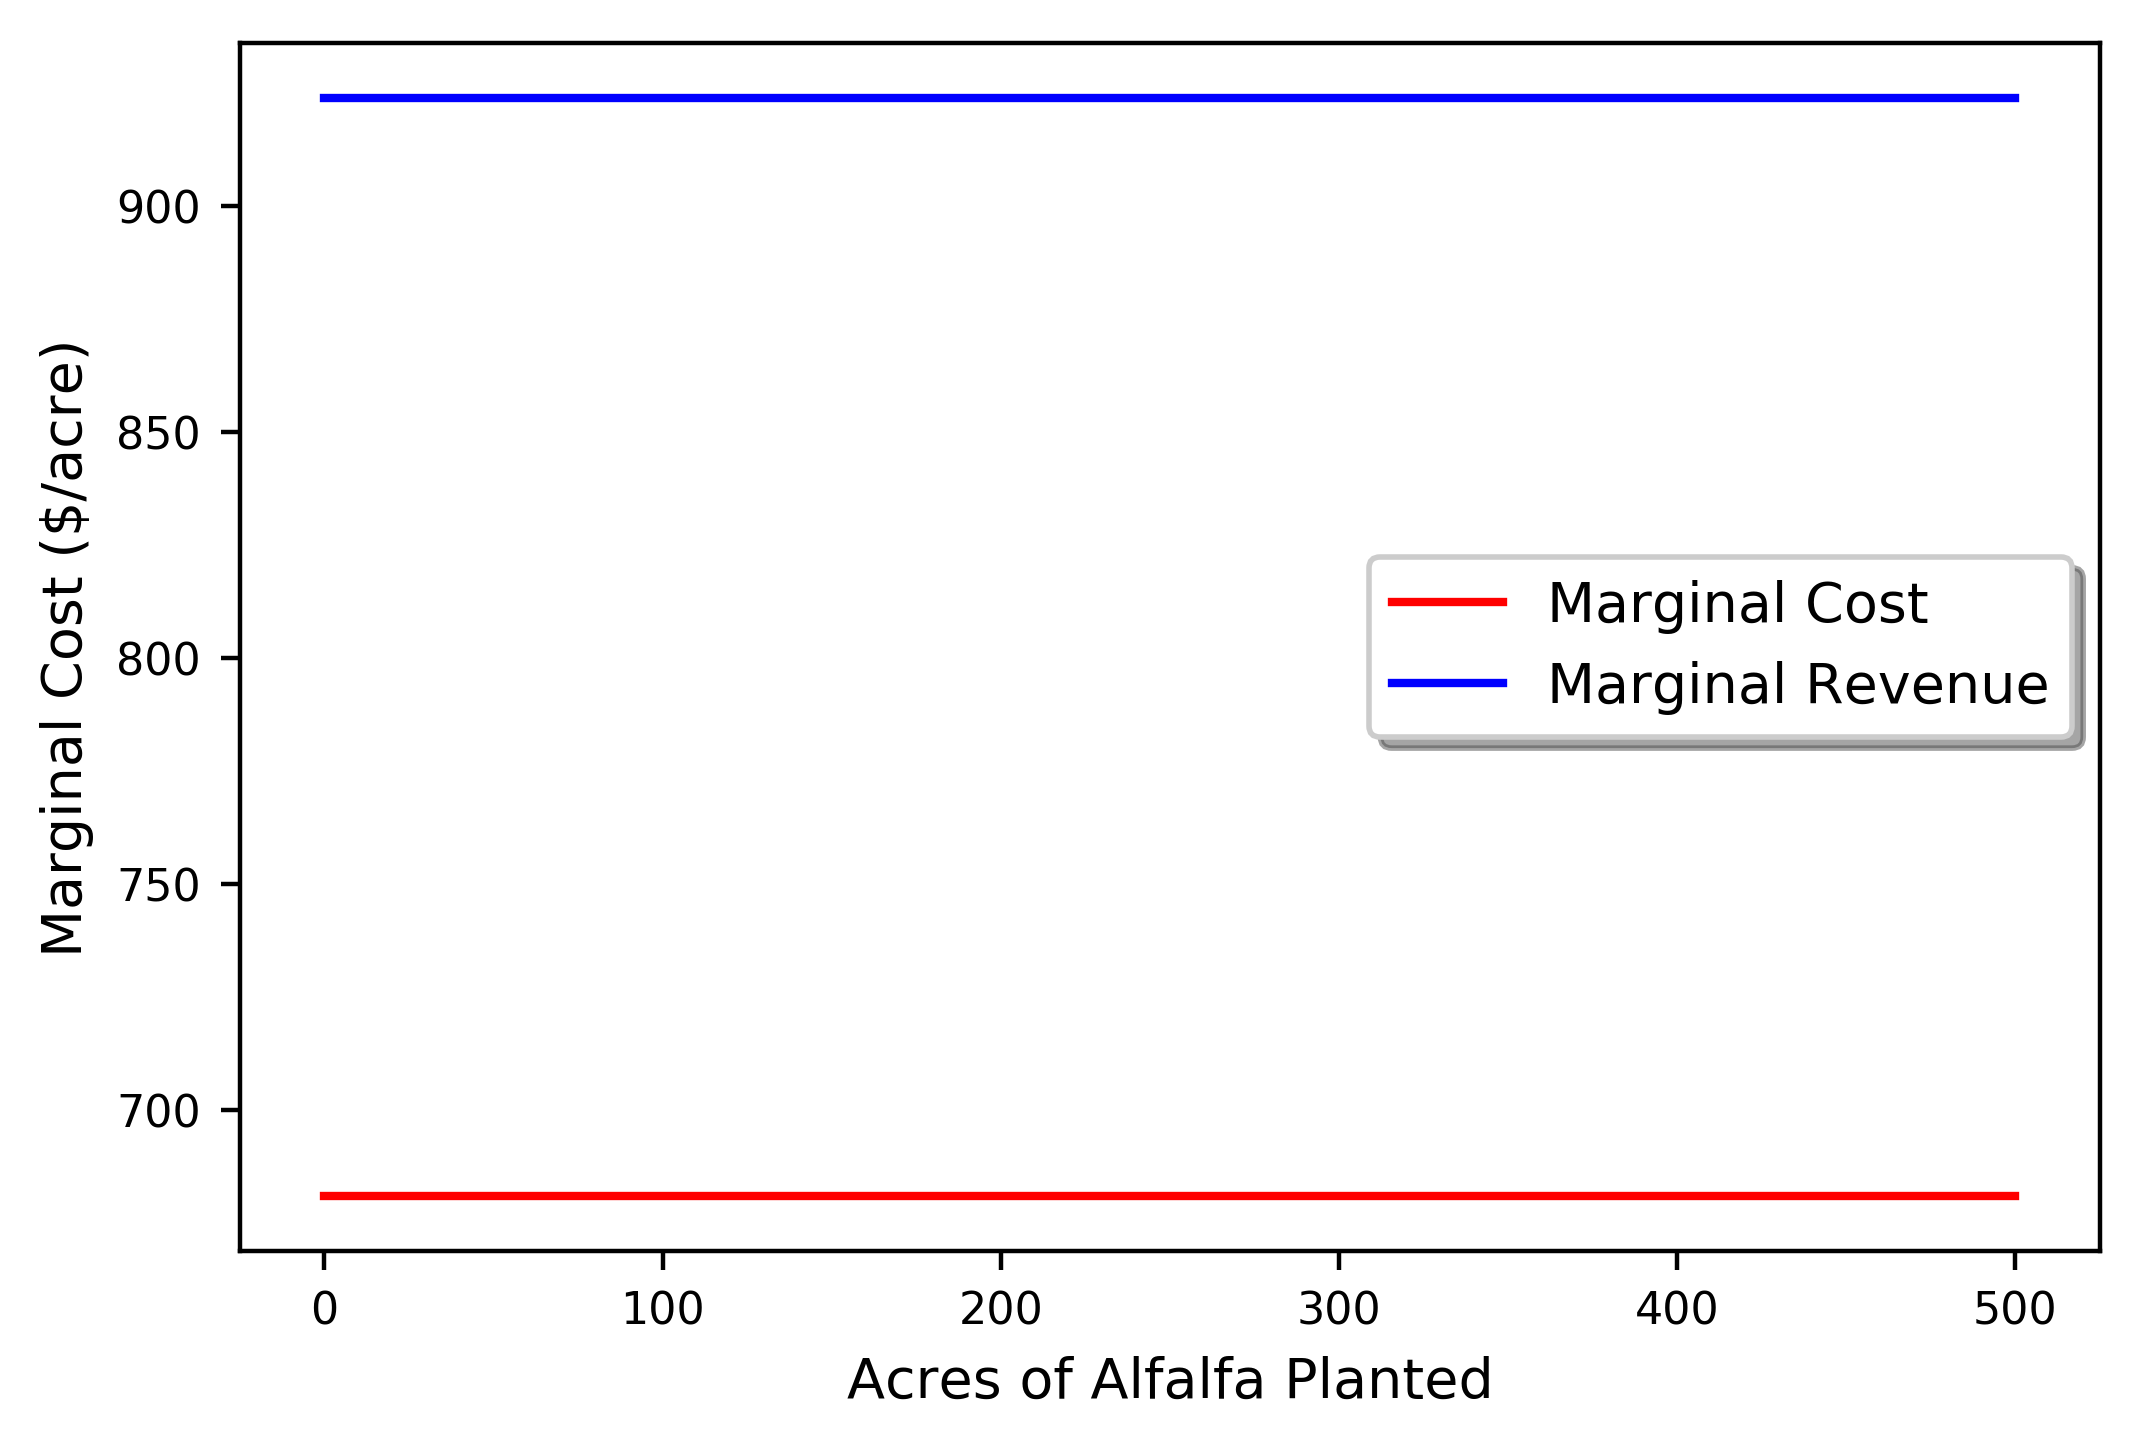

In [19]:
#graph the marginal costs
t = linspace(0, 500)

vine = alfalfa_params[0]  + alfalfa_params[1] * t 
vine_total = crop_revenues[0] + 0 * t


plt.figure(dpi=400)
plt.ylabel('Marginal Cost ($/acre)')
plt.xlabel('Acres of Alfalfa Planted')

plt.plot(t, vine, 'r', label='Marginal Cost')
plt.plot(t, vine_total, 'b', label='Marginal Revenue')

# plt.ylim((0,7))
plt.tick_params(labelsize=8)

legend = plt.legend(loc=7, shadow=True)
plt.show()

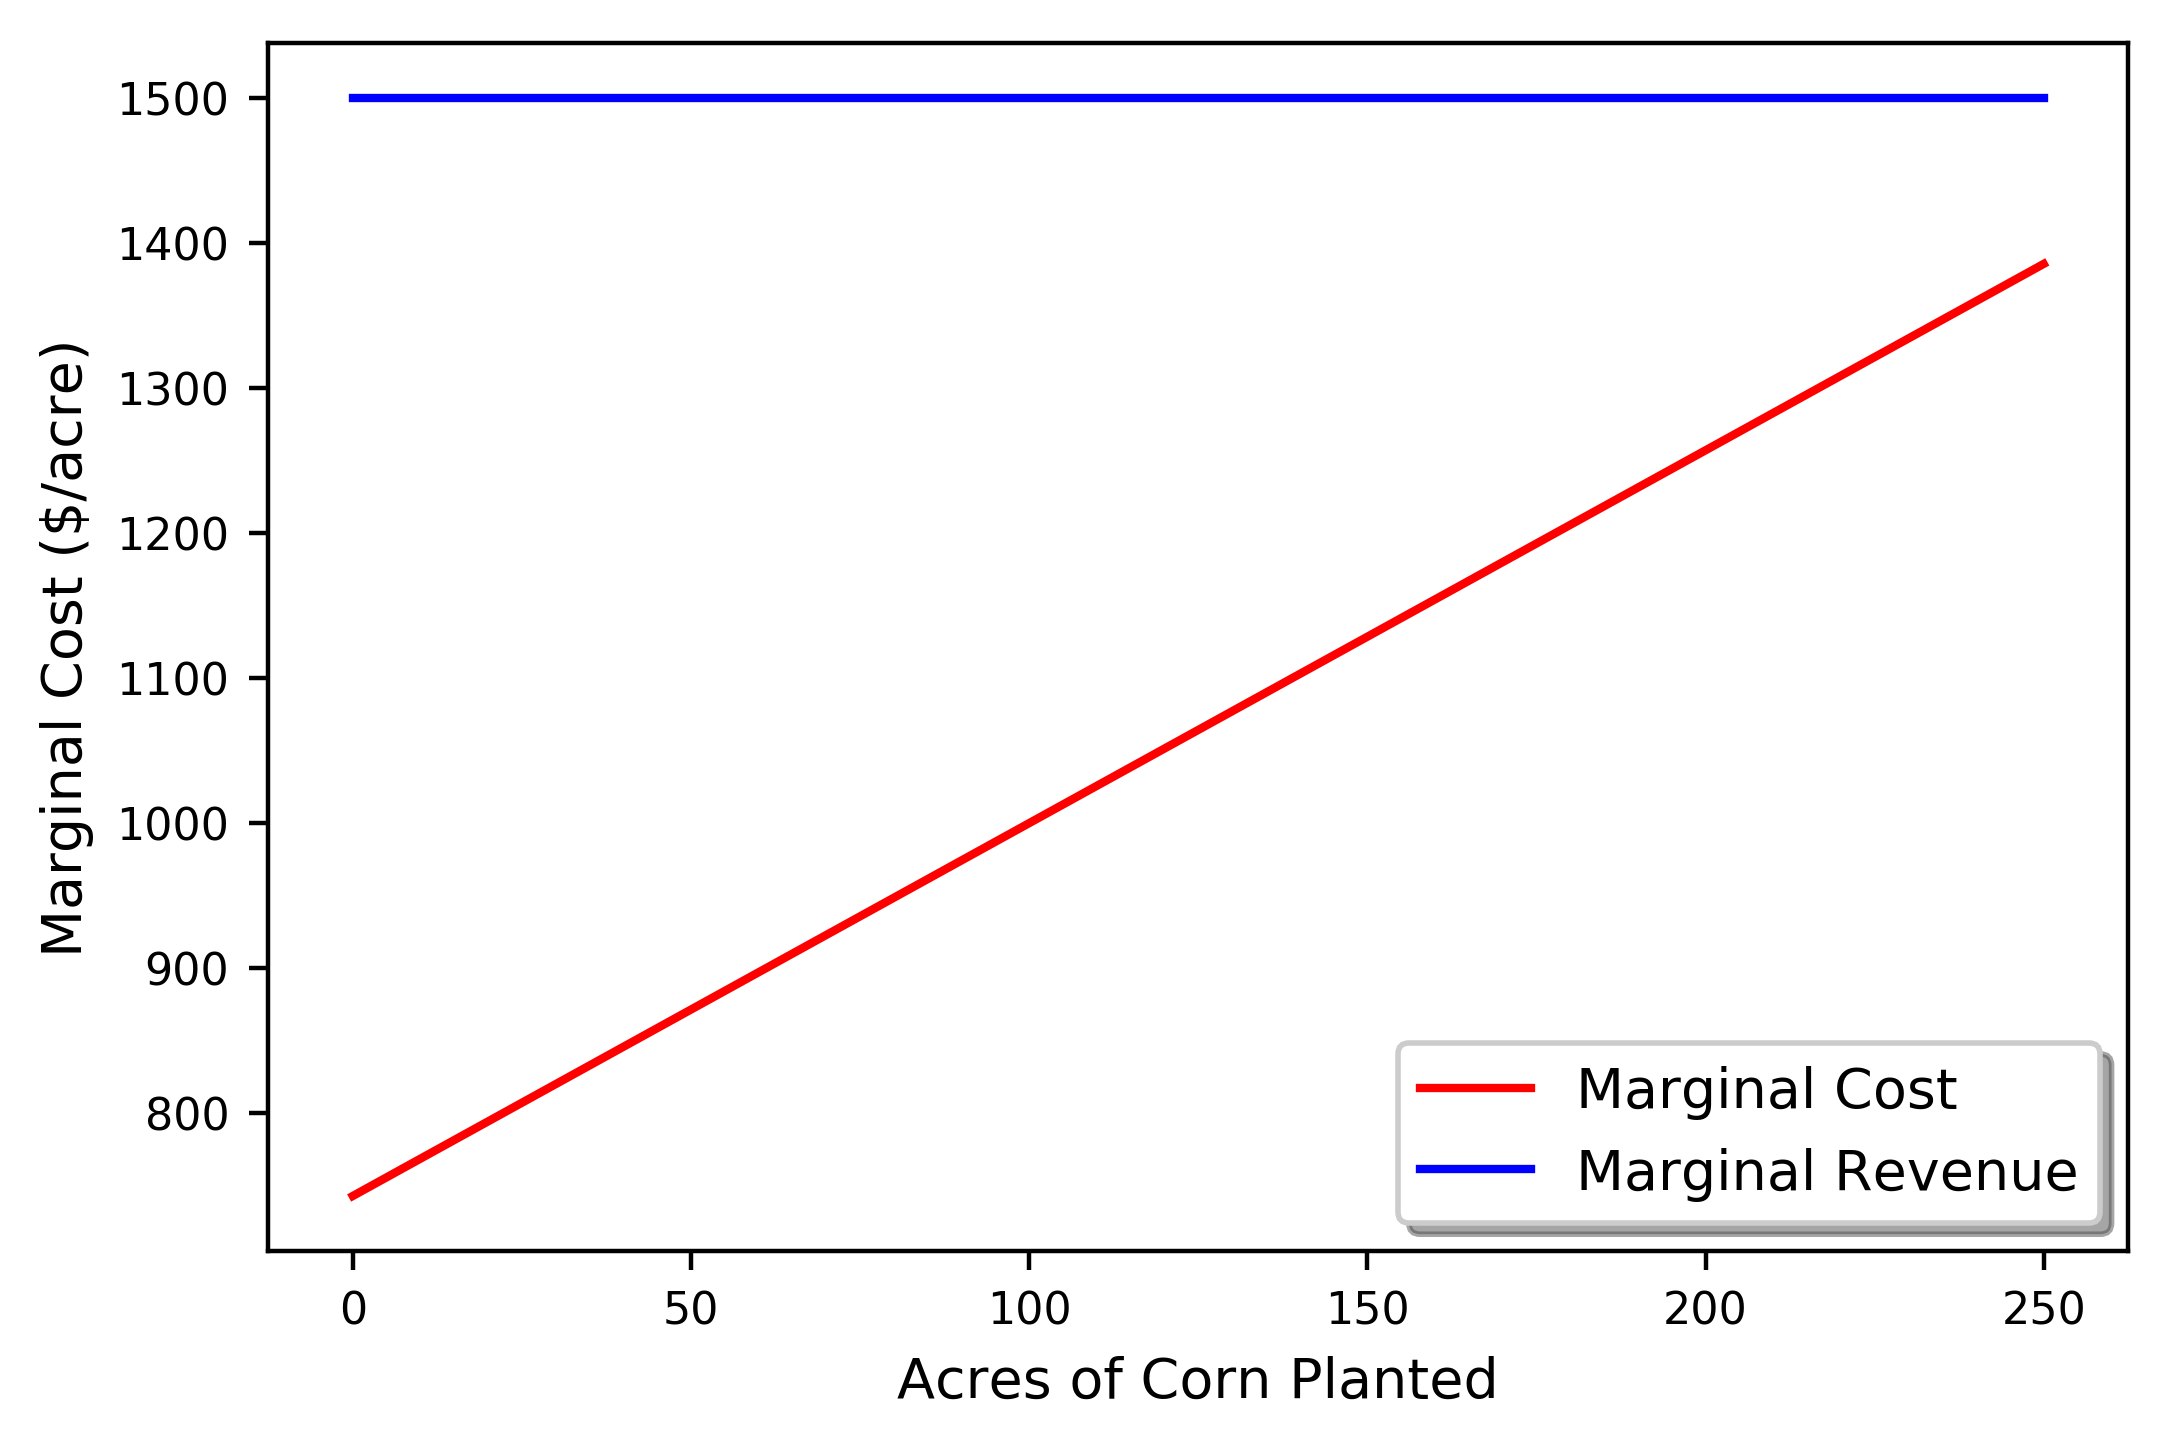

[  0.           5.10204082  10.20408163  15.30612245  20.40816327
  25.51020408  30.6122449   35.71428571  40.81632653  45.91836735
  51.02040816  56.12244898  61.2244898   66.32653061  71.42857143
  76.53061224  81.63265306  86.73469388  91.83673469  96.93877551
 102.04081633 107.14285714 112.24489796 117.34693878 122.44897959
 127.55102041 132.65306122 137.75510204 142.85714286 147.95918367
 153.06122449 158.16326531 163.26530612 168.36734694 173.46938776
 178.57142857 183.67346939 188.7755102  193.87755102 198.97959184
 204.08163265 209.18367347 214.28571429 219.3877551  224.48979592
 229.59183673 234.69387755 239.79591837 244.89795918 250.        ]


In [20]:
#graph the marginal costs
t = linspace(0, 250)

vine = corn_params[0]  + corn_params[1] * t 
vine_total = crop_revenues[2] + 0 * t


plt.figure(dpi=400)
plt.ylabel('Marginal Cost ($/acre)')
plt.xlabel('Acres of Corn Planted')

plt.plot(t, vine, 'r', label='Marginal Cost')
plt.plot(t, vine_total, 'b', label='Marginal Revenue')

# plt.ylim((0,7))
plt.tick_params(labelsize=8)

legend = plt.legend(loc=4, shadow=True)
plt.show()
print(t)

In [25]:
from IPython.html.widgets import *
%matplotlib inline
#revenues
revenue_per_acre = 250 * 6 #cost/ton * tons/acre
#irrigated acres
irrigated_acres = 200
#cost per acre to produce
crop_costs = 1000

#graph the marginal costs
def mc_curve(shadow_price=257, irrigated_acres=200, x_max=350):

    #calculate the alpha and gamma parameter values for quadratic form
    gamma = 2 * (shadow_price / irrigated_acres)
    alpha = crop_costs - shadow_price
    
    #set the x-axis limits
    t = linspace(0, x_max)

    #MC is derivative of total cost function
    corn_MC = alpha  + gamma * t 
    #marginal benefits is simply the revenue per acre
    corn_MB = revenue_per_acre + 0 * t


    plt.figure(dpi=150)
    plt.ylabel('Marginal Cost ($/acre)')
    plt.xlabel('Acres of Corn Planted')


    plt.plot(t, corn_MC, 'r', label='Marginal Cost')
    plt.plot(t, corn_MB, 'b', label='Marginal Revenue')
    

    plt.tick_params(labelsize=8)

    legend = plt.legend(loc=4, shadow=True)

    plt.show()


slider = interactive(mc_curve, shadow_price=(0, 1100, 10), irrigated_acres=(0.01,400, 10), x_max=(30, 350, 10))
display(slider)

interactive(children=(IntSlider(value=257, description='shadow_price', max=1100, step=10), FloatSlider(value=2…

In [22]:
lagrange_mults

[0.0, 828.9999813113245, 257.0001142922265]

In [ ]:
import matplotlib

#graph the marginal costs
t = linspace(0, 500)

vine = alfalfa_params[0]  + alfalfa_params[1] * t 
vine_total = crop_revenues[0] + 0 * t


plt.figure(dpi=400)
plt.ylabel('Marginal Cost ($/acre)')
plt.xlabel('Acres of Alfalfa Planted')

plt.plot(t, vine, 'r', label='Marginal Cost')
plt.plot(t, vine_total, 'b', label='Marginal Revenue')

# plt.ylim((0,7))
plt.tick_params(labelsize=8)

legend = plt.legend(loc=7, shadow=True)
plt.show()